<a href="https://colab.research.google.com/github/ks4617/ASTR-Leistedt-1/blob/main/Bayesian_clean.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

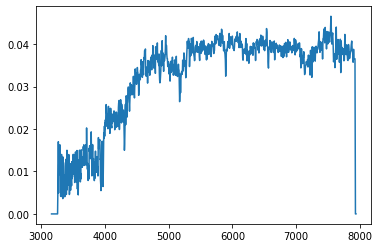

Number of capped errors 6756


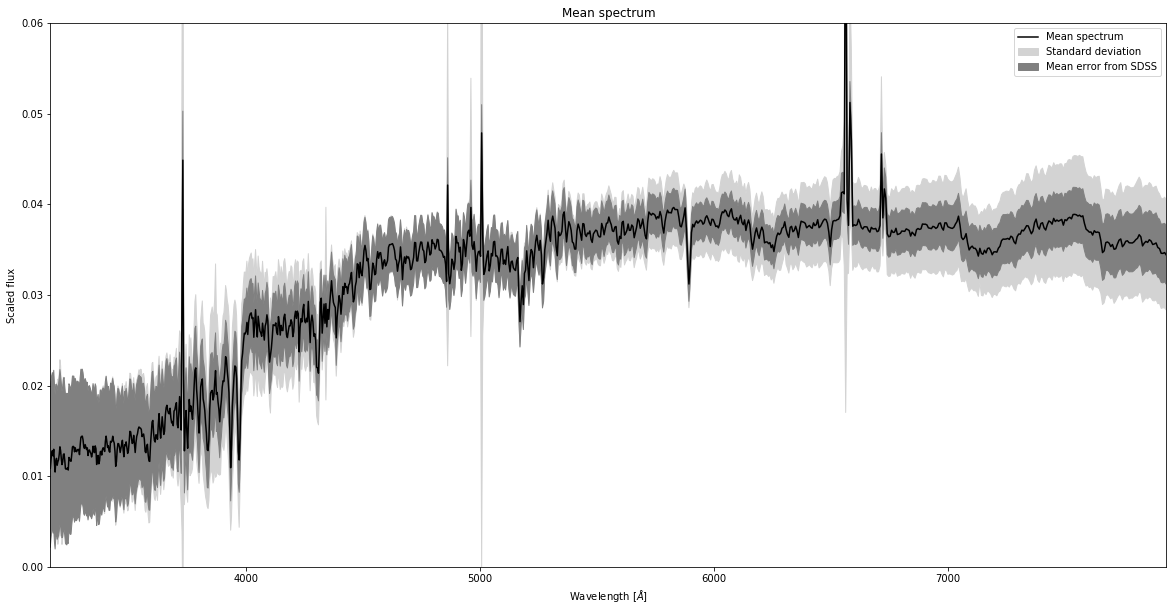

In [1]:

#%%
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.decomposition import PCA
from numpy.linalg import inv
from numpy.linalg import slogdet
from scipy.optimize import minimize

#%% Load full data set
data = np.load('spec4000error.npz')

#%% Calculating wavlength grid from coefficients

log_wavelengths = data['coeff0'] + data['coeff1'] * np.arange(0, 1000, 1)
wavelengths = [10**i for i in log_wavelengths]

#%% Selecting only galaxies (spec_cln = 2)

galaxy_ind = data['spec_cln'] == 2
X = data['spectra'][galaxy_ind]
subclass = data['lineindex_cln'][galaxy_ind]
z = data['z'][galaxy_ind]
z_err = data['zerr'][galaxy_ind]
spec_err = data['spec_err'][galaxy_ind]

#%% Set any negative spikes in flux to zero and set the corresponding error to zero

neg_ind = X <= 0.
X[neg_ind] = 0.
spec_err[neg_ind] = 0.

#%% Set zero fluxes to NaN

X_nonan = X.copy()
zero_ind = X == 0.
X[zero_ind] = np.NaN

#%% Set all zero and negative flux errors to NaN

zero_err_ind = spec_err <= 0.
spec_err[zero_err_ind] = np.NaN

#%% Normalise spectrum
X_normal, norm = preprocessing.normalize(X_nonan, return_norm=True)
X_norm_zeros = np.copy(X_normal)

#%% Plot an example spectrum in the data
plt.figure()
plt.plot(wavelengths,X_normal[4])
plt.show()

#%% Set all zero normalised fluxes to nan
zero_norm_ind = X_normal == 0.
X_normal[zero_norm_ind] = np.NaN

#%% Transform errors due to corresponding normalisation
spec_err_T = np.transpose(spec_err)
spec_err_norm_T = np.divide(spec_err_T,norm)
spec_err_norm = np.transpose(spec_err_norm_T)

# %% Cap errors at a lower limit of 1e-5 times the flux
cap_counter = 0
for spectra in range(len(spec_err_norm)):
    for pixel in range(len(spec_err_norm[spectra])):
        if np.isnan(spec_err_norm[spectra][pixel]) == False and spec_err_norm[spectra][pixel] < 1e-5 * X_normal[spectra][pixel]:
            spec_err_norm[spectra][pixel] = 1e-5 * X_normal[spectra][pixel]
            cap_counter += 1
print("Number of capped errors", cap_counter)

#%% Spectra errors with infs instead of nans
spec_err_norm_inf = np.nan_to_num(spec_err_norm,nan=np.inf)

#%% Plot mean spectrum
mu = np.nanmean(X_normal, axis=0)
std = np.nanstd(X_normal, axis=0)
#mu = X_norm_zeros.mean(0)
#std = X_norm_zeros.std(0)
mean_err = np.nanmean(spec_err_norm, axis=0)
plt.figure(figsize=(20,10))
plt.plot(wavelengths, mu, color = 'black', label='Mean spectrum')
plt.fill_between(wavelengths, mu - std, mu + std , color = 'lightgrey', label='Standard deviation')
plt.fill_between(wavelengths, mu - mean_err, mu + mean_err , color = 'grey', label = 'Mean error from SDSS')
plt.xlim(wavelengths[0], wavelengths[-1])
plt.ylim(0,0.06)
plt.xlabel('Wavelength [$\AA$]')
plt.ylabel('Scaled flux')
plt.title('Mean spectrum')
plt.legend()
plt.show()

#%% Apply PCA
pca = PCA(n_components=1000)
X_red = pca.fit_transform(X_norm_zeros)

#%% Fill spectra minus mean to be filled with zeros at nan values
X_mu = X_normal - mu
X_mu_zeros = np.nan_to_num(X_mu,nan=0.)


In [4]:
W_0 = pca.components_

In [28]:
# def objective_function1(W,X_mu_zeros,n1,n2):

    
#     spec_err1 = spec_err_norm_inf[n1:n2]

#     l_n = np.zeros([np.shape(spec_err1)[0]])
#     ident = np.identity(np.shape(W)[0])
#     sig_inv_diag_arr = spec_err1**(-2)
    
#     for i in range(np.shape(spec_err1)[0]):
#         sig_inv_diag = sig_inv_diag_arr[i]
#         #sig_inv_diag = spec_err1[i]**-2
#         #sig_inv_diag[sig_inv_diag==0.] = np.NaN
#         sig_inv = np.diagflat(sig_inv_diag)
#         sig_inv_W = sig_inv_diag[:,None]*W
#         M = ident + np.matmul(W.T,sig_inv_W)
#         M_inv = inv(M)
        
#         C_inv = sig_inv -  np.matmul(sig_inv_W, np.matmul(M_inv, sig_inv_W.T))

#         sign_M, logdet_M = slogdet(M)

#         sig_inv_diag[sig_inv_diag==0.] = np.NaN
#         logdet_sig = np.nansum(np.log(sig_inv_diag))
#         l_n[i] = -0.5*X_mu_zeros.shape[1]*np.log(2*np.pi) - 0.5*(logdet_M - logdet_sig) - 0.5*np.matmul(X_mu_zeros[i].T,np.matmul(C_inv,X_mu_zeros[i]))
    
#     return -sum(l_n)

### CORRECTED OBJECTIVE_FUNCTION1

In [31]:
def objective_function1(W,X_mu_zeros,spec_err_norm_inf,n1,n2):
    spec_err1 = spec_err_norm_inf[n1:n2]
    X_1 = X_mu_zeros[n1:n2]
    #l_n = np.zeros([np.shape(spec_err1)[0]])
    ln_total = 0
    ident = np.identity(np.shape(W)[0])
    sig_inv_diag_arr = spec_err1**(-2)
    
    for i in range(np.shape(spec_err1)[0]):
        sig_inv_diag = sig_inv_diag_arr[i]
        #sig_inv_diag = spec_err1[i]**-2
        #sig_inv_diag[sig_inv_diag==0.] = np.NaN
        sig_inv = np.diagflat(sig_inv_diag)
        sig_inv_W = sig_inv_diag[:,None]*W
        M = ident + np.matmul(W.T,sig_inv_W)
        M_inv = inv(M)
        
        C_inv = sig_inv -  np.matmul(sig_inv_W, np.matmul(M_inv, sig_inv_W.T))

        sign_M, logdet_M = slogdet(M)

        sig_inv_diag[sig_inv_diag==0.] = np.NaN
        logdet_sig = np.nansum(np.log(sig_inv_diag))
        ln_total += -0.5*X_1.shape[1]*np.log(2*np.pi) - 0.5*(logdet_M - logdet_sig) - 0.5*np.matmul(X_1[i].T,np.matmul(C_inv,X_1[i]))
    
    return -ln_total

In [32]:
#objective_function1(W_0,X_mu_zeros,0,3872)
objective_function1(W_0,X_mu_zeros,spec_err_norm_inf,0,100)

-179532.97207154726

In [ ]:
n1 = 0
n2 = 100

res = minimize(
    objective_function1,
    x0=W_0,
    args=(n1,n2),
)

In [4]:
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random

In [21]:
# with Jax instead of numpy

W_0 = pca.components_

def objective_function2(W,X_mu_zeros,n1,n2):

    
    spec_err1 = spec_err_norm_inf[n1:n2]

    l_n = jnp.zeros([np.shape(spec_err1)[0]])
    ident = jnp.identity(np.shape(W)[0])
    sig_inv_diag_arr = spec_err1**(-2)
    
    for i in range(np.shape(spec_err1)[0]):
        sig_inv_diag = sig_inv_diag_arr[i]
        sig_inv = jnp.diagflat(sig_inv_diag)
        sig_inv_W = sig_inv_diag[:,None]*W
        M = ident + jnp.matmul(W.T,sig_inv_W)
        M_inv = inv(M)
        
        C_inv = sig_inv -  jnp.matmul(sig_inv_W, jnp.matmul(M_inv, sig_inv_W.T))

        sign_M, logdet_M = slogdet(M)

        sig_inv_diag[sig_inv_diag==0.] = np.NaN
        logdet_sig = jnp.nansum(jnp.log(sig_inv_diag))
        l_n[i] = -0.5*X_mu_zeros.shape[1]*jnp.log(2*jnp.pi) - 0.5*(logdet_M - logdet_sig) - 0.5*jnp.matmul(X_mu_zeros[i].T,jnp.matmul(C_inv,X_mu_zeros[i]))
    
    return -sum(l_n)

In [22]:
objective_function2(W_0,X_mu_zeros,0,2)

TypeError: ignored